**import libraries**

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math 
import regex as re
from scipy import stats
from scipy.stats import randint
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from tqdm import tqdm

**load dataset**

In [17]:
data = pd.read_csv('employee_reviews_sub.csv')

#delete the useless column
data = data.drop(['Unnamed: 0'], axis= 1)
data = data.drop(['link'], axis= 1)
#data = data.drop(['dates'], axis= 1)
#data = data.drop(['helpful-count'], axis= 1)

In [18]:
data.head()

,company,location,dates,job-title,overall-ratings,work-balance-stars,culture-values-stars,carrer-opportunities-stars,comp-benefit-stars,senior-mangemnet-stars,helpful-count
0,google,none,"Dec 11, 2018",Current Employee - Anonymous Employee,5.0,4.0,5.0,5.0,4.0,5.0,0
1,google,"Mountain View, CA","Jun 21, 2013",Former Employee - Program Manager,4.0,2.0,3.0,3.0,5.0,3.0,2094
2,google,"New York, NY","May 10, 2014",Current Employee - Software Engineer III,5.0,5.0,4.0,5.0,5.0,4.0,949
3,google,"Mountain View, CA","Feb 8, 2015",Current Employee - Anonymous Employee,5.0,2.0,5.0,5.0,4.0,5.0,498
4,google,"Los Angeles, CA","Jul 19, 2018",Former Employee - Software Engineer,5.0,5.0,5.0,5.0,5.0,5.0,49


In [4]:
data.dtypes

company                        object
location                       object
job-title                      object
overall-ratings               float64
work-balance-stars             object
culture-values-stars           object
carrer-opportunities-stars     object
comp-benefit-stars             object
senior-mangemnet-stars         object
helpful-count                   int64
dtype: object

### Data Engeneering

**Average ratings for different feature (by company)**

We use these information to fill the missing values

In [19]:
ratings_comp = data[["company", 'overall-ratings', "work-balance-stars", "culture-values-stars", "carrer-opportunities-stars", "comp-benefit-stars", "senior-mangemnet-stars"]].copy()
ratings_comp.set_index(["company"], inplace=True)
ratings_comp = ratings_comp[~(ratings_comp[['overall-ratings',"work-balance-stars", "culture-values-stars", "carrer-opportunities-stars", "comp-benefit-stars", "senior-mangemnet-stars"]] == "none").any(axis=1)]
ratings_comp[['overall-ratings',"work-balance-stars", "culture-values-stars", "carrer-opportunities-stars", "comp-benefit-stars", "senior-mangemnet-stars"]] = ratings_comp[['overall-ratings',"work-balance-stars", "culture-values-stars", "carrer-opportunities-stars", "comp-benefit-stars", "senior-mangemnet-stars"]].apply(pd.to_numeric)
avg_company = ratings_comp.groupby("company")['overall-ratings',"work-balance-stars", "culture-values-stars", "carrer-opportunities-stars", "comp-benefit-stars", "senior-mangemnet-stars"].mean()
avg_company.columns = ['Overall Ratings',"Work Balance", "Culture Values", "Career Opportunities", "Company Benefits", "Senior Management"]
avg_company = avg_company.transpose()
avg_company

<ipython-input-19-83d9e7432d94>:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  avg_company = ratings_comp.groupby("company")['overall-ratings',"work-balance-stars", "culture-values-stars", "carrer-opportunities-stars", "comp-benefit-stars", "senior-mangemnet-stars"].mean()


company,amazon,apple,facebook,google,microsoft,netflix
Overall Ratings,3.605707,3.958919,4.518081,4.378480,3.859934,3.497976
Work Balance,3.010915,3.338017,3.904729,4.004104,3.575086,3.210526
Culture Values,3.532292,4.097873,4.515299,4.359208,3.657359,3.514170
Career Opportunities,3.621241,3.419399,4.365090,4.030692,3.710211,3.157895
Company Benefits,3.710779,4.059036,4.573018,4.427552,4.025453,4.257085
Senior Management,3.171875,3.446916,4.260779,3.871877,3.185432,3.192308


**filling missing values with the average for attribute for each company**

In [22]:
companies=pd.unique(data['company'])
#in the following dict are stored the mean values for each comapany and each attribute using the previous dataframe avg_company
ratings_per_company={company: avg_company.loc[:,company].values for company in companies}  #companies are keys whereas values are the different ratings

for index,row in tqdm(data.iterrows()):  #for each row in the dataset  
    company=data.iloc[index,0]  #company name
    for index_y in range(4,10):  #for each column from overall ratings to helpful-count       
        if data.iloc[index,index_y]=='none':
            data.iloc[index,index_y]=round(ratings_per_company.get(company)[index_y-4],1)
            

67529it [00:39, 1701.53it/s]


In [23]:
#converting dtypes
data['culture-values-stars']=pd.to_numeric(data['culture-values-stars'])
data['work-balance-stars']=pd.to_numeric(data['work-balance-stars'])
data['carrer-opportunities-stars']=pd.to_numeric(data['carrer-opportunities-stars'])
data['comp-benefit-stars']=pd.to_numeric(data['comp-benefit-stars'])
data['senior-mangemnet-stars']=pd.to_numeric(data['senior-mangemnet-stars'])

#### Use the data only with location in California

In [24]:
data_CA=data['location'].filter(regex='CA$',axis=0)
california_loc=pd.unique(list(filter(lambda loc:re.findall(r'CA$',loc),data['location'])))
data_CA=data[data['location'].isin(california_loc)]
data_CA.head()

,company,location,dates,job-title,overall-ratings,work-balance-stars,culture-values-stars,carrer-opportunities-stars,comp-benefit-stars,senior-mangemnet-stars,helpful-count
1,google,"Mountain View, CA","Jun 21, 2013",Former Employee - Program Manager,4.0,2.0,3.0,3.0,5.0,3.0,2094
3,google,"Mountain View, CA","Feb 8, 2015",Current Employee - Anonymous Employee,5.0,2.0,5.0,5.0,4.0,5.0,498
4,google,"Los Angeles, CA","Jul 19, 2018",Former Employee - Software Engineer,5.0,5.0,5.0,5.0,5.0,5.0,49
5,google,"Mountain View, CA","Dec 9, 2018",Former Employee - SDE2,5.0,4.0,4.0,4.0,5.0,4.0,1
10,google,"Mountain View, CA","Dec 8, 2018",Current Employee - Anonymous Employee,5.0,4.0,5.0,4.0,4.0,3.0,0


In [32]:
data_CA['year'] = pd.to_datetime(data_CA['dates'], errors='coerce').dt.year
#del data_CA['dates']

<ipython-input-32-dd0fabdf354d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_CA['year'] = pd.to_datetime(data_CA['dates'], errors='coerce').dt.year


In [35]:
data_CA

,company,location,job-title,overall-ratings,work-balance-stars,culture-values-stars,carrer-opportunities-stars,comp-benefit-stars,senior-mangemnet-stars,helpful-count,year
1,google,"Mountain View, CA",Former Employee - Program Manager,4.0,2.0,3.0,3.0,5.0,3.0,2094,2013
3,google,"Mountain View, CA",Current Employee - Anonymous Employee,5.0,2.0,5.0,5.0,4.0,5.0,498,2015
4,google,"Los Angeles, CA",Former Employee - Software Engineer,5.0,5.0,5.0,5.0,5.0,5.0,49,2018
5,google,"Mountain View, CA",Former Employee - SDE2,5.0,4.0,4.0,4.0,5.0,4.0,1,2018
10,google,"Mountain View, CA",Current Employee - Anonymous Employee,5.0,4.0,5.0,4.0,4.0,3.0,0,2018
...,...,...,...,...,...,...,...,...,...,...,...
61897,microsoft,"San Francisco, CA",Current Employee - Premier Field Engineer,4.0,3.5,3.7,4.0,4.5,4.0,0,2008
61898,microsoft,"San Francisco, CA",Current Employee - Software Development Engineer,5.0,4.5,3.7,5.0,4.5,4.0,2,2008
61899,microsoft,"San Francisco, CA",Current Employee - Senior Product Manager,3.0,4.0,3.7,4.0,4.0,4.0,0,2008
61900,microsoft,"San Francisco, CA",Current Employee - Account Executive,5.0,4.5,3.7,5.0,4.0,4.0,1,2008


### Save a dataframe for each company. We are going to do the analysis on each of them

**google**

In [36]:
google=data_CA[data_CA['company']=='google']
google.to_csv('google.csv')

**amazon**

In [37]:
amazon=data_CA[data_CA['company']=='amazon']
amazon.to_csv('amazon.csv')

**apple**

In [38]:
apple=data_CA[data_CA['company']=='apple']
apple.to_csv('apple.csv')

**microsoft**

In [39]:
microsoft=data_CA[data_CA['company']=='microsoft']
microsoft.to_csv('microsoft.csv')

**netflix**

In [40]:
netflix=data_CA[data_CA['company']=='netflix']
netflix.to_csv('netflix.csv')

**facebook**

In [41]:
facebook=data_CA[data_CA['company']=='facebook']
facebook.to_csv('facebook.csv')

## Data analysis and visualization

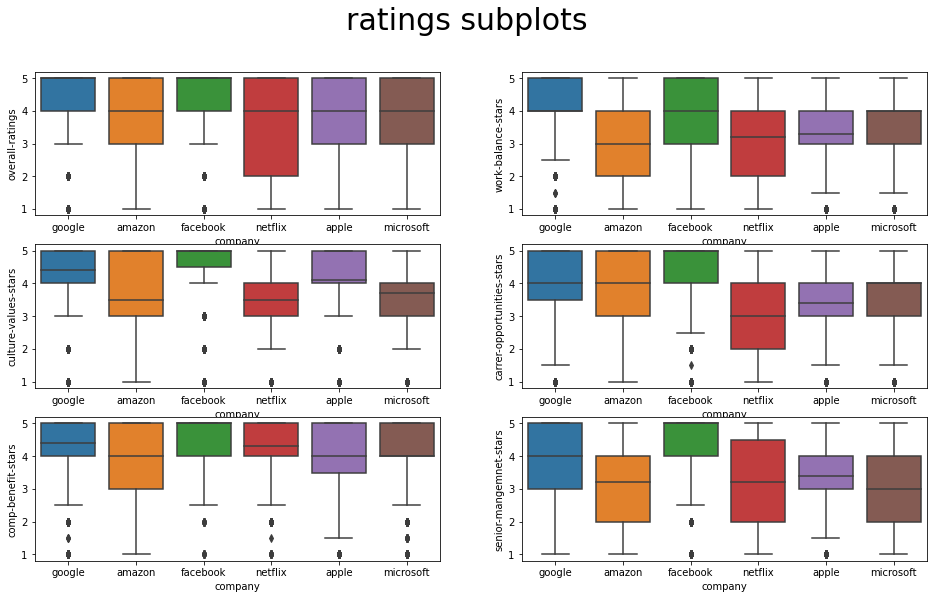

In [31]:
from seaborn import boxplot as bp
fig,axes=plt.subplots(nrows=3,ncols=2,figsize=(16,9))
fig.suptitle('ratings subplots',fontsize=30)
bp(x='company',y='overall-ratings',data=data,ax=axes[0,0])
bp(x='company',y='work-balance-stars',data=data,ax=axes[0,1])
bp(x='company',y='culture-values-stars',data=data,ax=axes[1,0])
bp(x='company',y='carrer-opportunities-stars',data=data,ax=axes[1,1])
bp(x='company',y='comp-benefit-stars',data=data,ax=axes[2,0])
bp(x='company',y='senior-mangemnet-stars',data=data,ax=axes[2,1])
plt.show()

#### Distribution of Reviews by year

c:\users\stefania\appdata\local\programs\python\python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


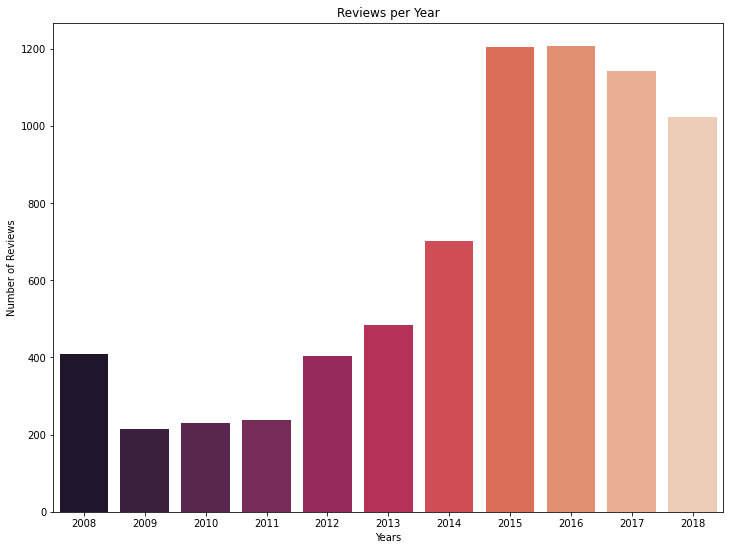

In [42]:
years_count = data_CA['year'].value_counts().sort_index(ascending=True)
years_labels = years_count.index.tolist()
years_index = np.arange(len(years_labels))

plt.figure(figsize=(12, 9))
_ = sns.barplot(years_index, years_count, palette='rocket')
_ = plt.xticks(years_index, years_labels)
_ = plt.xlabel("Years")
_ = plt.ylabel("Number of Reviews")
_ = plt.title("Reviews per Year")

### Which company takes the best treatment for the employees? 

In [69]:
def rating_per_company(rating_type, title, color):
    work_ratings = data[['company', rating_type]]
    work_ratings = work_ratings[~(work_ratings[[rating_type]] == "none").any(axis=1)]
    work_ratings[rating_type] = work_ratings[rating_type].apply(pd.to_numeric)
    group = work_ratings.groupby(work_ratings["company"].str.title())[rating_type].mean().reset_index()
    group.sort_values([rating_type],inplace=True)
    group.set_index('company').plot.barh(legend=False, figsize=(12, 10), color=color)
    plt.title('{} Rating'.format(title))
    plt.xlabel('Rating')
    _ = plt.ylabel('Companies')

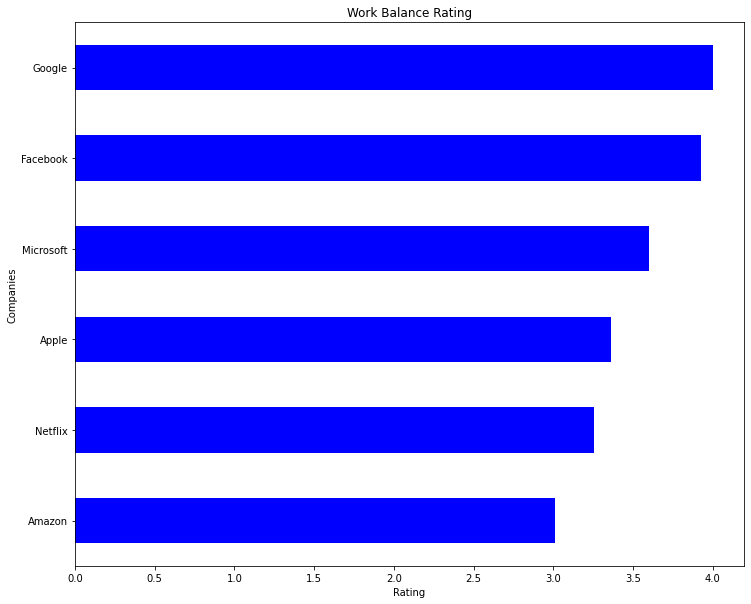

In [72]:
# Which company offers better Work-Life Balance?
rating_per_company('work-balance-stars', "Work Balance", "b")

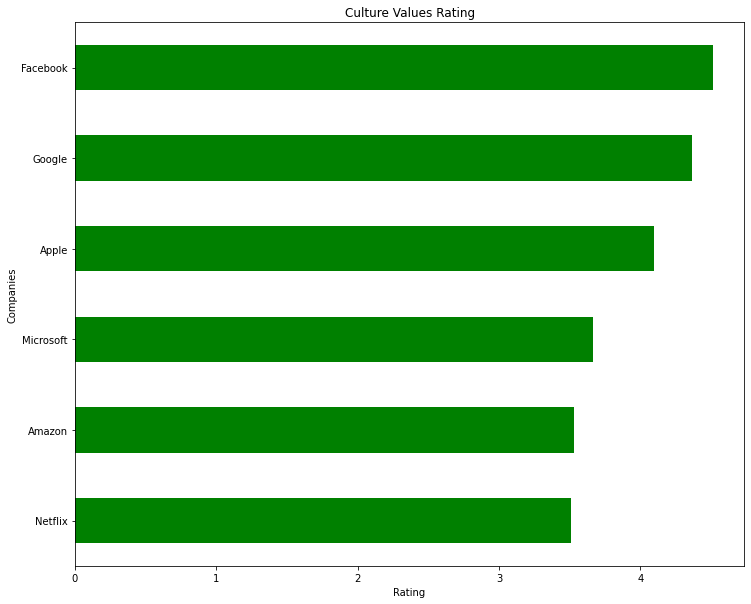

In [74]:
#Which company has better Culture Values?
rating_per_company('culture-values-stars', "Culture Values", "g")

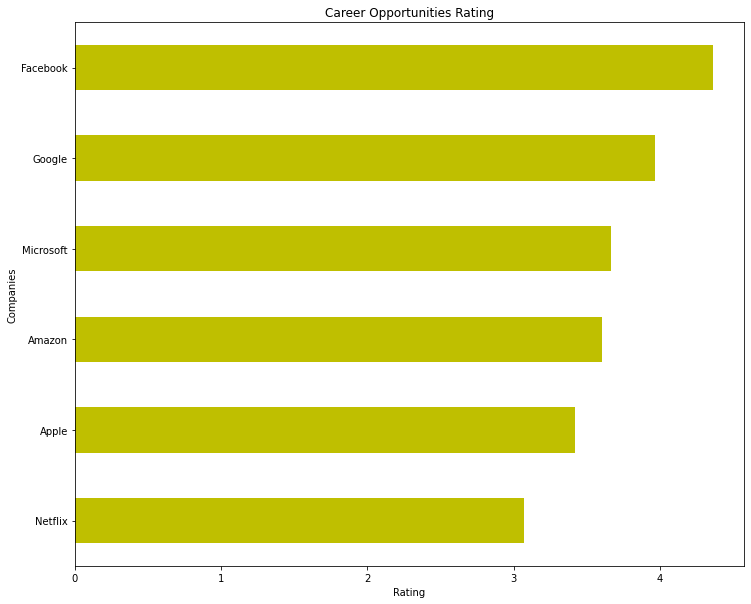

In [77]:
#Which company has better Career Opportunities?
rating_per_company("carrer-opportunities-stars", "Career Opportunities", "y")

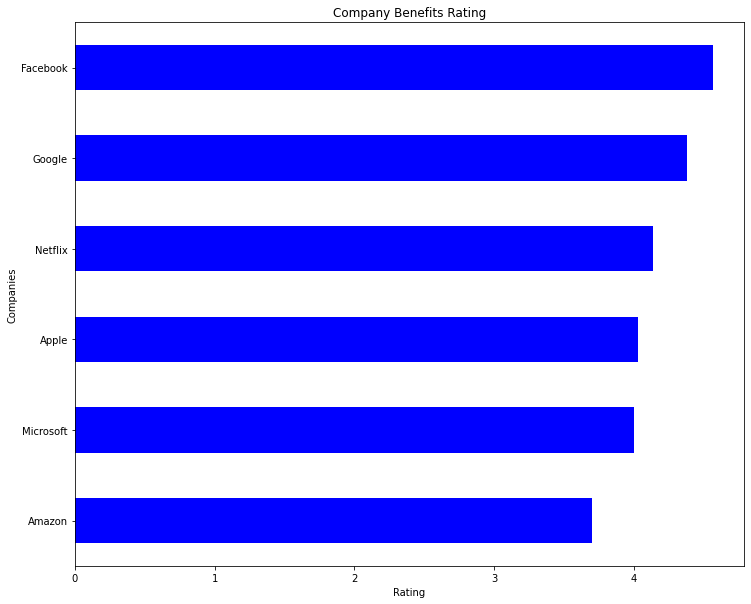

In [82]:
rating_per_company("comp-benefit-stars", "Company Benefits", "b")

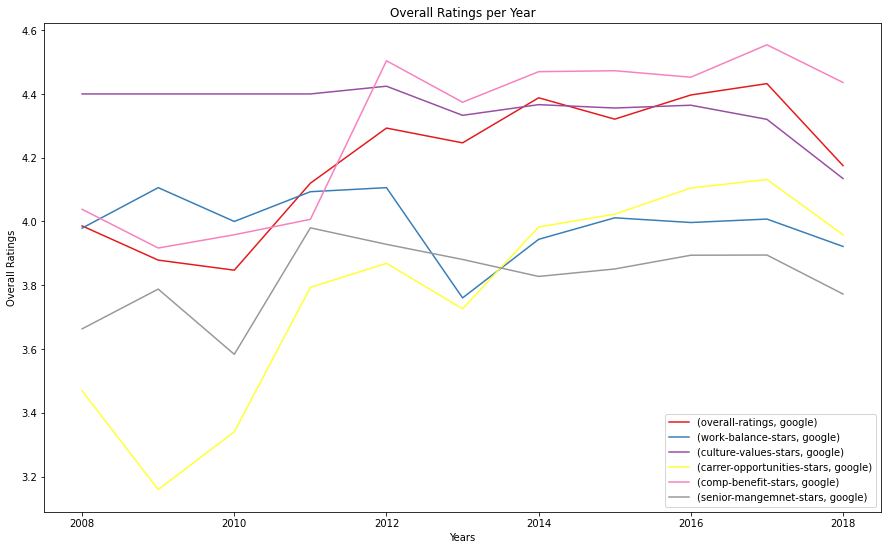

In [83]:
#Ratings over time for Google
fig, ax = plt.subplots(figsize=(15,9))
keys = ['year','company']
lines = ['overall-ratings','work-balance-stars','culture-values-stars','carrer-opportunities-stars','comp-benefit-stars','senior-mangemnet-stars']
google.groupby(keys)[lines].mean().unstack().plot(ax=ax,colormap = 'Set1')
_ = plt.xlabel("Years")
_ = plt.ylabel("Overall Ratings")
_ = plt.title("Overall Ratings per Year")
_ = plt.legend()

## Normalizing the dataframe

In [89]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler() #for normalize the values
data_norm= scaler.fit_transform(data)

In [90]:
data_new=pd.DataFrame(data_norm,columns=["overall-ratings","work-balance-stars","culture-values-stars","carrer-opportunities-stars","comp-benefit-stars","senior-mangemnet-stars","Company_code","Job_code","Locations_code"])

In [91]:
data_new.head()

,overall-ratings,work-balance-stars,culture-values-stars,carrer-opportunities-stars,comp-benefit-stars,senior-mangemnet-stars,Company_code,Job_code,Locations_code
0,1.00,0.75,1.00,1.0,0.75,1.00,0.6,0.030336,0.998042
1,0.75,0.25,0.50,0.5,1.00,0.50,0.6,0.840496,0.599119
2,1.00,1.00,0.75,1.0,1.00,0.75,0.6,0.495125,0.623103
3,1.00,0.25,1.00,1.0,0.75,1.00,0.6,0.030336,0.599119
4,1.00,1.00,1.00,1.0,1.00,1.00,0.6,0.930661,0.516887


#### Now that we have only encoded data and the values are normalize, we can explore the correlations 

#### Correlation

In [92]:
corr_matrix = data_new.corr()
corr_matrix

,overall-ratings,work-balance-stars,culture-values-stars,carrer-opportunities-stars,comp-benefit-stars,senior-mangemnet-stars,Company_code,Job_code,Locations_code
overall-ratings,1.000000,0.585635,0.690138,0.661697,0.518004,0.692403,0.101173,-0.144581,0.010044
work-balance-stars,0.585635,1.000000,0.553058,0.461134,0.419234,0.569505,0.223218,-0.088567,-0.000793
culture-values-stars,0.690138,0.553058,1.000000,0.550567,0.446241,0.682125,0.069189,-0.115278,-0.022884
carrer-opportunities-stars,0.661697,0.461134,0.550567,1.000000,0.508801,0.625193,0.050472,-0.115430,0.020906
comp-benefit-stars,0.518004,0.419234,0.446241,0.508801,1.000000,0.469461,0.157892,-0.043127,0.014209
senior-mangemnet-stars,0.692403,0.569505,0.682125,0.625193,0.469461,1.000000,0.025666,-0.126515,0.000835
Company_code,0.101173,0.223218,0.069189,0.050472,0.157892,0.025666,1.000000,0.054548,0.071848
Job_code,-0.144581,-0.088567,-0.115278,-0.115430,-0.043127,-0.126515,0.054548,1.000000,-0.190683
Locations_code,0.010044,-0.000793,-0.022884,0.020906,0.014209,0.000835,0.071848,-0.190683,1.000000


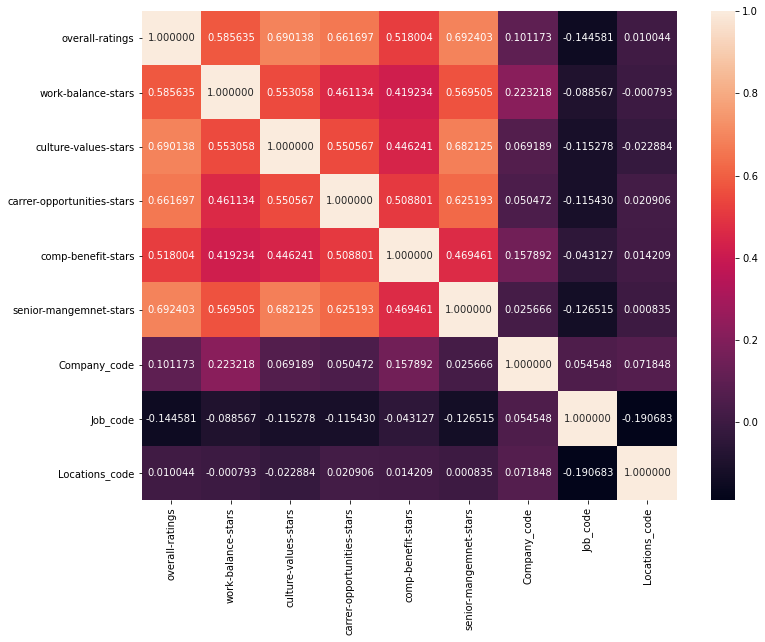

In [93]:
plt.figure(figsize=(12, 9))
sns.heatmap(corr_matrix, annot=True, fmt="f");

### Causal inference

In [34]:
import dowhy

## Classification 

In [63]:
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.svm import SVC
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier

In [124]:
# Encoding categorical data
ord_enc = OrdinalEncoder()

apple["Job_code"]=ord_enc.fit_transform(apple[["job-title"]])
apple["location_code"]=ord_enc.fit_transform(apple[["location"]])


google["Job_code"]=ord_enc.fit_transform(google[["job-title"]])
google["location_code"]=ord_enc.fit_transform(google[["location"]])


facebook["Job_code"]=ord_enc.fit_transform(facebook[["job-title"]])
facebook["location_code"]=ord_enc.fit_transform(facebook[["location"]])

### Train - test splitting

In [79]:
# we have to choose which cols are our features and which one is the target
# apple_jobs=apple[apple['Job_code']!=17.0]
# X = apple_jobs[['location_code','Job_code','work-balance-stars','culture-values-stars','carrer-opportunities-stars','comp-benefit-stars','senior-mangemnet-stars','overall-ratings']]
# y = apple_jobs['helpful-count']
# # split X and y into training and testing sets selecting at random the 30% of the rows and assigning them to the test_set
# X_train_apple, X_test_apple, y_train_apple, y_test_apple = train_test_split(X, y, test_size=0.30, random_state=42)

google_jobs=google[google['Job_code']!=17.0]
X = google_jobs[['location_code','work-balance-stars','culture-values-stars','carrer-opportunities-stars','comp-benefit-stars','senior-mangemnet-stars','overall-ratings']]
y = google_jobs['helpful-count']
# split X and y into training and testing sets selecting at random the 30% of the rows and assigning them to the test_set
X_train_google, X_test_google, y_train_google, y_test_google = train_test_split(X, y, test_size=0.30, random_state=42)

### KNN Classifier

In [123]:
model=KNN()
model.fit(X_train_google,y_train_google)
model.score(X_test_google,y_test_google)

### SVM Classifier

In [122]:
model_1=SVC()
model_1.fit(X_train_google,y_train_google)
model_1.score(X_test_google,y_test_google)

### Decision tree Classifier

In [119]:
model_2=DecisionTreeClassifier()
model_2.fit(X_train_google,y_train_google)
model_2.score(X_test_google,y_test_google)